# **Practical Work 3 - CNN**
Done By: Hugo Cisneros, Javier de Santos, Alicia García and Fernando Teba

## **Libraries and Imports**

In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

from shutil import move

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing import image
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras import Input
from keras import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import signal
import random
import shutil

## **Functions used in the notebook**

In [ ]:
# Function to display input picture alongside predicted categories
def display_prediction(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(96, 96))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    # Make predictions
    predictions = model.predict(img_array)

    # Get the top three predicted categories and their probabilities
    top_categories = np.argsort(predictions[0])[::-1][:3]
    top_probs = predictions[0][top_categories]

    # Display the input picture
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Display the top three predicted categories and their probabilities
    print("Top 3 Predicted Categories:")
    for i in range(3):
        print(f"{i+1}. Category: {classes[top_categories[i]]}, Probability: {top_probs[i]}")

In [ ]:
def evaluation(model_eval):
  predictions = model_eval.predict(test_generator)

  y_pred = np.argmax(predictions, axis=1)  # Predicted labels
  y_real = test_generator.classes         # True labels

  # Calculate precision, recall, F1-score, and support for each class
  precision, recall, f1_score, support = precision_recall_fscore_support(y_real, y_pred, average='weighted')

  # Print the classification report
  print(metrics.classification_report(y_real, y_pred, digits=4))

In [ ]:
def print_images_folder(path):
    # Lists for storing images information and classes
    num_images = []
    classes = []

    # Iterate over each folder in the specified directory
    for folder in os.listdir(path):
        # Full path of the folder
        folder_path = os.path.join(path, folder)

        # Check if it's a folder
        if os.path.isdir(folder_path):
            # Count the number of images in the folder
            images_count = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

            # Add the folder name and the number of images to the lists
            classes.append(folder)
            num_images.append(images_count)

    # Bar plot
    plt.figure(figsize=(8, 6))
    plt.bar(classes, num_images, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution for each class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## **Step 1.1 - Environment Preparation**

**Examine the dataset to identify the classes and the features. This dataset includes a labels file named driver_imgs_list.csv.**

With this snippet we intend to load the zip generated in the Kaggle website, and once loaded we want to analyze it.First, we load the Zip file and extract it on the file site.

In [ ]:
zip_path = '/content/drive/My Drive/state-farm-distracted-driver-detection.zip'
zip_ref = zipfile.ZipFile(zip_path, 'r')
zip_ref.extractall('./content')

Then, we analyze it by looking for its classes and features.

In [ ]:
data = pd.read_csv("/content/content/driver_imgs_list.csv")

print(data.head())

classes = data['classname'].unique()
print("Classes:", classes)

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg
Classes: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']


**Label the images based on the driver_imgs_list.csv file using the labeling technique of your choice: (1) individual labeling; or (2) directory-based labeling (if necessary).**

We conclude that it has 10 classes to be categorized and the features of the data is that are JPG images. Now, we would create the new folders as we are creating a directory-based labbeling system for the dataset. The dataset provided in the Kaggle website is wrong labeled, meaning there is 76000 images unlabeled and 22000 labeled. In this case, we would only use the 22000 images. The labeling technique used in this dataset is the directory-based labeling.


In [ ]:
# Training path
train_folder = '/content/content/imgs/train'

# Testing path
test_folder = '/content/dataset/imgs/Test'

# Validation path
validation_folder = '/content/dataset/imgs/Validation'

# Last Training Dataset path
final_train_folder = '/content/dataset/imgs/Training'

# Classes detected before
classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

# We now created the folder classes where the images of each specific class is going to be allocated.
for class_name in classes:

    test_class_folder = os.path.join(test_folder, class_name)
    validation_class_folder = os.path.join(validation_folder, class_name)
    final_train_class_folder = os.path.join(final_train_folder, class_name)

    if not os.path.exists(test_class_folder):
        os.makedirs(test_class_folder)
    if not os.path.exists(validation_class_folder):
        os.makedirs(validation_class_folder)
    if not os.path.exists(final_train_class_folder):
        os.makedirs(final_train_class_folder)

Once the directories are created, we comence by moving the photos in the amounts asked on the practice heading: **a test set comprising 15% of the dataset prepared in the previous step. Split the remaining dataset into training (90%) and validation (10%) sets.**

In [ ]:
# Percentage of how the validation and testing set are divided from the training set.
test_percentage = 0.15
validation_percentage = 0.10

# For each folder in the directory.
for class_name in classes:

    train_class_folder = os.path.join(train_folder, class_name) # The Train class folder
    test_class_folder = os.path.join(test_folder, class_name) # The Test class folder
    validation_class_folder = os.path.join(validation_folder, class_name) # THe Validation folder
    final_train_class_folder = os.path.join(final_train_folder, class_name) # The new Train class folder

    # We obtain all the images in the train folder.
    images = os.listdir(train_class_folder)
    num_images = len(images)

    # As the parameter is setted, we calculate how many images we move from the training dataset into the validation set.
    num_images_for_test = int(num_images * test_percentage)
    num_images_for_validation = int((num_images - num_images_for_test) * validation_percentage)

    # We select a random set of the images in the specific class for testing.
    images_for_test = random.sample(images, num_images_for_test)

    # We move the images from the training set into the test set (as it is a 15% from the training set)
    for image_name in images_for_test:
        src = os.path.join(train_class_folder, image_name)
        dst = os.path.join(test_class_folder, image_name)
        shutil.move(src, dst)

    #  We select a random set of the images in the specific class for validation.
    images_for_validation = random.sample(set(images) - set(images_for_test), num_images_for_validation)

    # We move the images from the training set into the validation set (as it is a 10% from the training set)
    for image_name in images_for_validation:
        src = os.path.join(train_class_folder, image_name)
        dst = os.path.join(validation_class_folder, image_name)
        shutil.move(src, dst)

    images = os.listdir(train_class_folder)

    # We moved the remaining images to the training dataset
    for image_name in images:
        src = os.path.join(train_class_folder, image_name)
        dst = os.path.join(final_train_class_folder, image_name)
        shutil.move(src, dst)

<ipython-input-10-681b7167e0a3>:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  images_for_validation = random.sample(set(images) - set(images_for_test), num_images_for_validation)


Printing the distribution in each folder.

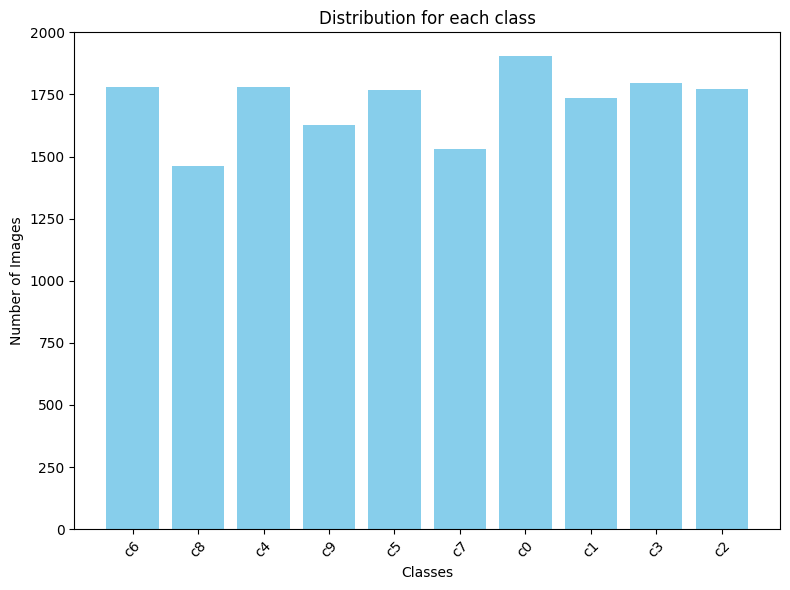

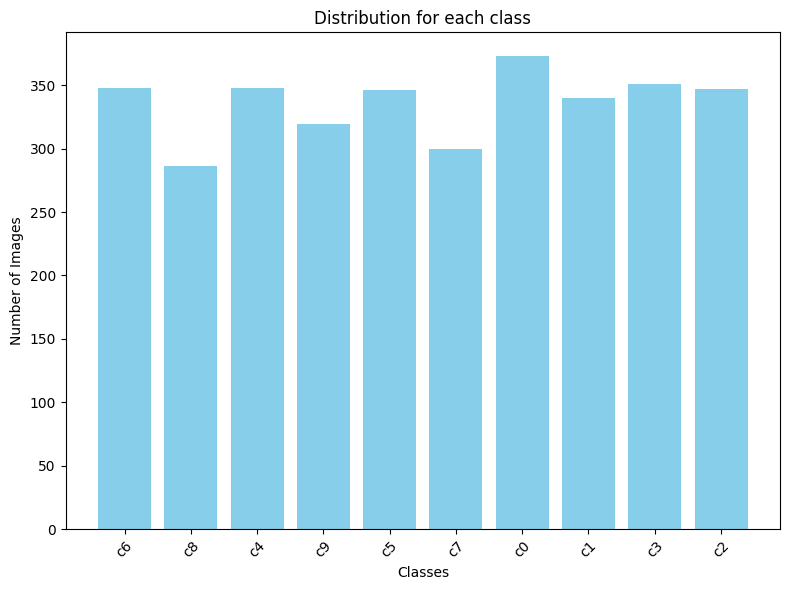

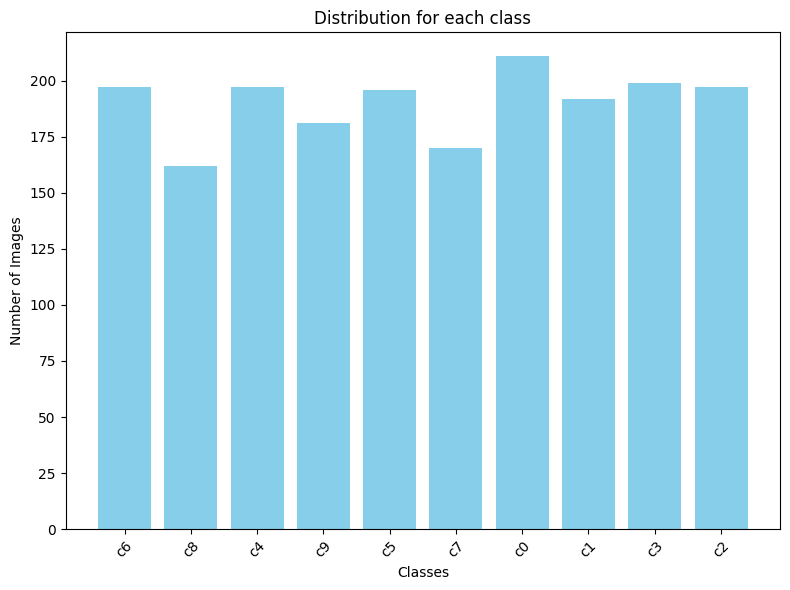

In [ ]:
print_images_folder('/content/dataset/imgs/Training')
print_images_folder('/content/dataset/imgs/Test')
print_images_folder('/content/dataset/imgs/Validation')

As it is clear, all the data is perfectly distributed, avoiding possible missbalanced in the datasets.

## **Step 1.2 - Data preparation**

Thanks to the ImageDataGenerator, we created three dataset: a training, validation and testing dataset.

In [ ]:
train_dir = "/content/dataset/imgs/Training"
val_dir = "/content/dataset/imgs/Validation"
test_dir = "/content/dataset/imgs/Test"
target_size = (96, 96)
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Data generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

# Data generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 17164 images belonging to 10 classes.
Found 1902 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.


## **Step 2 - Implementation**

All the models created below have been designed following these rules:

1. It must include at least 3 Convolutional layers.

2. It must use ReLU as activation function.

3. It must use softmax function for the ouput of the last layer.

4. It must use categorical crossentropy function as loss function.

5. It must use Adam algorithm for minizing the loss function.

In [ ]:
# Definition of the image sizes
input_size = 96
num_colors = 3
steps_per_epoch = 30
epochs = 150

### Models - Layers

Model extracted from previous exercises.

In [ ]:
# Definition of the network layers
layers = [
    # First convolution with 16 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(16,
                        (3,3),
                        activation='relu',
                        input_shape=(input_size,
                                    input_size,
                                    num_colors)),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2, 2),
    # Second convolution with 32 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(32,
                        (3,3),
                        activation='relu'),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2,2),
    # Third convolution with 96 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(96,
                        (3,3),
                        activation='relu'),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2,2),
    # Fourth convolution with 96 filters of size 3 x 3 and relu activation function
    keras.layers.Conv2D(96,
                        (3,3),
                        activation='relu'),
    # Pooling of size 2 x 2 and stride 1
    keras.layers.MaxPooling2D(2,2),
    # Flattening to transform the information into a vector
    keras.layers.Flatten(),
    # Dense layer with 128 neurons and relu activation function
    keras.layers.Dense(128,
                       activation='relu'),
    # Output layer with softmax activation function
    keras.layers.Dense(10,
                       activation = tf.nn.softmax),
]

model = keras.Sequential(layers, name="car_multiclass_classification")

# Optimization algorithm and loss function configuration
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model.summary()

Model: "car_multiclass_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 96)        27744     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1

Model created having in mind a dropout layer. It prevents dependencies between neurons and promotes model robustness by making it less sensitive to small variations in the input data. It helps to prevent overfitting and improve the model's generalization ability.

In [ ]:
layers_dropout = [
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_size, input_size, num_colors)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation= tf.nn.softmax)
]

model_dropout = keras.Sequential(layers_dropout, name="car_multiclass_classification_dropout")

# Optimization algorithm and loss function configuration
model_dropout.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model_dropout.summary()

Model: "car_multiclass_classification_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  

In this model, we added more filters in order to try to improve its capacity to learn complex features, enhance feature representation, increase robustness to variations in the input data, facilitate hierarchical feature learning, and provide additional capacity for transfer learning

In [ ]:
layers_more_filters = [
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_size, input_size, num_colors)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation= tf.nn.softmax)
]

model_more_filters = keras.Sequential(layers_more_filters, name="car_multiclass_classification_more_filters")

# Optimization algorithm and loss function configuration
model_more_filters.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model_more_filters.summary()

Model: "car_multiclass_classification_more_filters"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_9 (MaxPoo

This model was created by adding more layers instead of neurons.

In [ ]:
model_regularized = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_size, input_size, num_colors)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation=tf.nn.softmax)
],name="car_multiclass_classification_regularized")

# Optimization algorithm and loss function configuration
model_regularized.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Network structure
model_regularized.summary()

Model: "car_multiclass_classification_regularized"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_12 (MaxPoo

### Training Process

**Model extracted from previous exercises - Training**

In [ ]:
checkpoint_filepath = '/content/dataset/models'

if not os.path.exists(checkpoint_filepath):
    os.makedirs(checkpoint_filepath)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

tensorboard_callback = TensorBoard(
    log_dir = 'logs')

**Model from previous exercise - Training**

In [ ]:
# Training process execution
history = model.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data=validation_generator,
                    callbacks = [tensorboard_callback])

#saved_model = keras.models.load_model(checkpoint_filepath)

# Evaluation of the model using the test set
evaluation(model)

Epoch 1/150
30/30 [==============================] - 13s 265ms/step - loss: 2.3075 - accuracy: 0.1010 - val_loss: 2.3017 - val_accuracy: 0.1009
Epoch 2/150
30/30 [==============================] - 8s 254ms/step - loss: 2.3020 - accuracy: 0.1073 - val_loss: 2.2996 - val_accuracy: 0.1009
Epoch 3/150
30/30 [==============================] - 8s 257ms/step - loss: 2.2996 - accuracy: 0.1115 - val_loss: 2.2959 - val_accuracy: 0.1788
Epoch 4/150
30/30 [==============================] - 8s 256ms/step - loss: 2.2974 - accuracy: 0.1302 - val_loss: 2.2829 - val_accuracy: 0.1272
Epoch 5/150
30/30 [==============================] - 7s 252ms/step - loss: 2.2855 - accuracy: 0.1375 - val_loss: 2.2529 - val_accuracy: 0.1635
Epoch 6/150
30/30 [==============================] - 7s 251ms/step - loss: 2.2054 - accuracy: 0.1937 - val_loss: 2.1492 - val_accuracy: 0.2145
Epoch 7/150
30/30 [==============================] - 8s 257ms/step - loss: 2.0921 - accuracy: 0.2156 - val_loss: 2.0031 - val_accuracy: 0.244

**Model with a dropout layer - Training**

In [ ]:
# Training process execution
history_dropout = model_dropout.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data=validation_generator,
                    callbacks = [tensorboard_callback])

# Evaluation of the model using the test set
evaluation(model_dropout)

Epoch 1/150
30/30 [==============================] - 11s 255ms/step - loss: 2.3110 - accuracy: 0.1213 - val_loss: 2.3006 - val_accuracy: 0.1062
Epoch 2/150
30/30 [==============================] - 7s 251ms/step - loss: 2.3009 - accuracy: 0.1073 - val_loss: 2.2980 - val_accuracy: 0.1372
Epoch 3/150
30/30 [==============================] - 8s 257ms/step - loss: 2.3013 - accuracy: 0.1208 - val_loss: 2.3018 - val_accuracy: 0.1036
Epoch 4/150
30/30 [==============================] - 8s 259ms/step - loss: 2.3019 - accuracy: 0.0990 - val_loss: 2.2963 - val_accuracy: 0.1109
Epoch 5/150
30/30 [==============================] - 8s 257ms/step - loss: 2.2988 - accuracy: 0.1281 - val_loss: 2.2974 - val_accuracy: 0.1567
Epoch 6/150
30/30 [==============================] - 8s 256ms/step - loss: 2.2930 - accuracy: 0.1437 - val_loss: 2.2613 - val_accuracy: 0.1304
Epoch 7/150
30/30 [==============================] - 8s 257ms/step - loss: 2.2241 - accuracy: 0.1719 - val_loss: 2.1272 - val_accuracy: 0.258

**Model with more filters - Training**

In [ ]:
# Training process execution
history_filters = model_more_filters.fit(train_generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data=validation_generator,
                    callbacks = [tensorboard_callback])

# Evaluation of the model using the test set
evaluation(model_more_filters)

Epoch 1/150
30/30 [==============================] - 6s 124ms/step - loss: 2.3451 - accuracy: 0.0854
Epoch 2/150
30/30 [==============================] - 4s 131ms/step - loss: 2.3009 - accuracy: 0.1073
Epoch 3/150
30/30 [==============================] - 4s 132ms/step - loss: 2.3020 - accuracy: 0.1063
Epoch 4/150
30/30 [==============================] - 4s 131ms/step - loss: 2.3007 - accuracy: 0.1229
Epoch 5/150
30/30 [==============================] - 4s 129ms/step - loss: 2.3017 - accuracy: 0.1000
Epoch 6/150
30/30 [==============================] - 4s 130ms/step - loss: 2.3016 - accuracy: 0.1063
Epoch 7/150
30/30 [==============================] - 4s 130ms/step - loss: 2.3008 - accuracy: 0.1146
Epoch 8/150
30/30 [==============================] - 4s 132ms/step - loss: 2.2990 - accuracy: 0.1240
Epoch 9/150
30/30 [==============================] - 4s 130ms/step - loss: 2.2933 - accuracy: 0.1354
Epoch 10/150
30/30 [==============================] - 4s 131ms/step - loss: 2.2839 - accura

**Regularized Model - Training**

In [ ]:
# Training process execution
history_regularized = model_regularized.fit(train_generator,
                                steps_per_epoch=steps_per_epoch,
                                epochs=epochs,
                                validation_data=validation_generator,
                                callbacks=[tensorboard_callback])

# Evaluation of the model using the test set
evaluation(model_regularized)

Epoch 1/150
30/30 [==============================] - 9s 255ms/step - loss: 2.3186 - accuracy: 0.0917 - val_loss: 2.3017 - val_accuracy: 0.1109
Epoch 2/150
30/30 [==============================] - 7s 252ms/step - loss: 2.3095 - accuracy: 0.1053 - val_loss: 2.3008 - val_accuracy: 0.1109
Epoch 3/150
30/30 [==============================] - 8s 255ms/step - loss: 2.3029 - accuracy: 0.0917 - val_loss: 2.3011 - val_accuracy: 0.1036
Epoch 4/150
30/30 [==============================] - 7s 252ms/step - loss: 2.3016 - accuracy: 0.1125 - val_loss: 2.3010 - val_accuracy: 0.1109
Epoch 5/150
30/30 [==============================] - 8s 259ms/step - loss: 2.3017 - accuracy: 0.1083 - val_loss: 2.3009 - val_accuracy: 0.1109
Epoch 6/150
30/30 [==============================] - 8s 254ms/step - loss: 2.3009 - accuracy: 0.1167 - val_loss: 2.2998 - val_accuracy: 0.1109
Epoch 7/150
30/30 [==============================] - 8s 253ms/step - loss: 2.3000 - accuracy: 0.1187 - val_loss: 2.2997 - val_accuracy: 0.1109

In [ ]:
model.save("/content/dataset/models/modelo.h5")
model_dropout.save("/content/dataset/models/model_dropout.h5")
model_more_filters.save("/content/dataset/models/model_more_filters.h5")
model_regularized.save("/content/dataset/models/model_regularized.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# files.download("/content/dataset/models/modelo.h5")
# files.download("/content/dataset/models/model_dropout.h5")
# files.download("/content/dataset/models/model_more_filters.h5")
# files.download("/content/dataset/models/model_regularized.h5")

## **Step 3 - Evaluation**

Display the input picture alongside the top three categories into which the model is most likely to classify the image, arranged in descending order of probability.

Random Class: c7
Random Image from previous class: img_4672.jpg
1/1 [==============================] - 0s 22ms/step


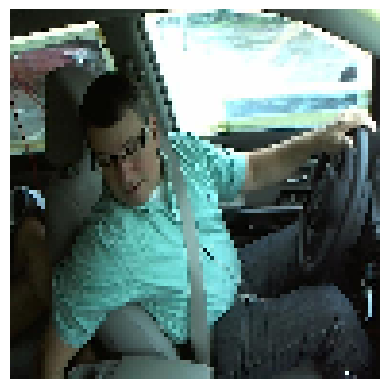

Top 3 Predicted Categories:
1. Category: c7, Probability: 0.9985091090202332
2. Category: c8, Probability: 0.0012458571000024676
3. Category: c2, Probability: 0.00023671802773606032


In [ ]:
# First, we obtained the list of classes
folders = os.listdir(test_dir)

# Select a random class
randmon_class = random.choice(folders)

# Path to the class
path_random_class = os.path.join(test_dir, randmon_class)

# Once the path to the class is selected, we listed the images contained there.
imgs_test = [imgs for imgs in os.listdir(path_random_class)]

# Select a random image
random_img = random.choice(imgs_test)

# Path to the image
random_img_path = os.path.join(path_random_class, random_img)

print("Random Class:", randmon_class)
print("Random Image from previous class:", random_img)

display_prediction(random_img_path, model_more_filters)

Generate the confusion matrix for the entire test set.

105/105 [==============================] - 7s 62ms/step


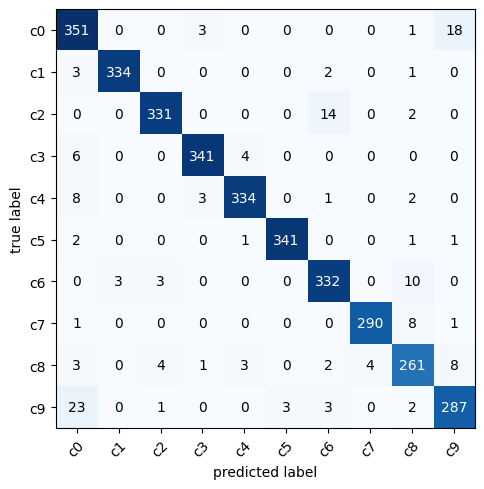

In [ ]:
predictions = model_more_filters.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), class_names = classes, show_normed=False)
plt.tight_layout()

## **Step 4 - Questions**

**Has your best model undergone optimal training? Provide justification for your response.**

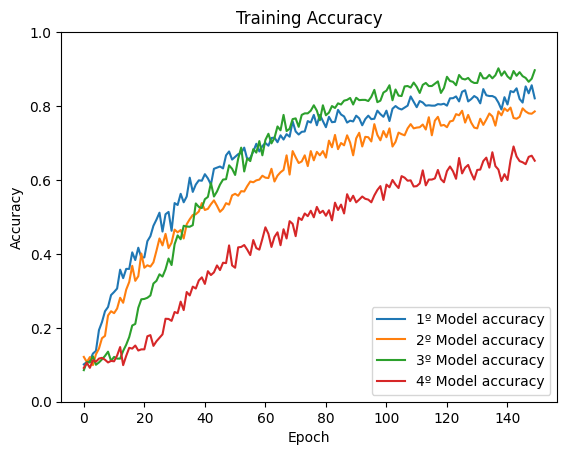

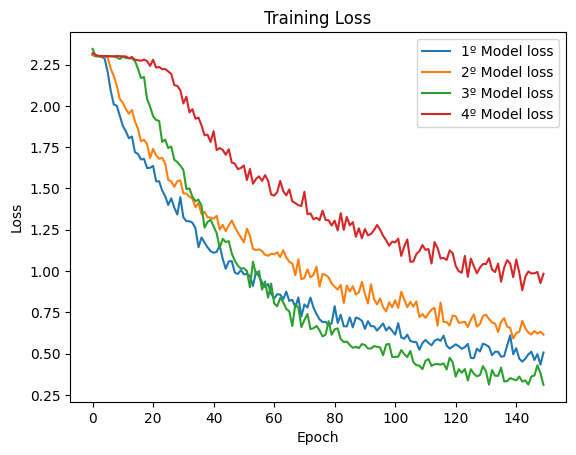

105/105 [==============================] - 7s 62ms/step
              precision    recall  f1-score   support

           0     0.8841    0.9410    0.9117       373
           1     0.9911    0.9824    0.9867       340
           2     0.9764    0.9539    0.9650       347
           3     0.9799    0.9715    0.9757       351
           4     0.9766    0.9598    0.9681       348
           5     0.9913    0.9855    0.9884       346
           6     0.9379    0.9540    0.9459       348
           7     0.9864    0.9667    0.9764       300
           8     0.9062    0.9126    0.9094       286
           9     0.9111    0.8997    0.9054       319

    accuracy                         0.9535      3358
   macro avg     0.9541    0.9527    0.9533      3358
weighted avg     0.9543    0.9535    0.9538      3358



In [ ]:
# Plot acurracy of the four models
plt.plot(history.history['accuracy'], label='1º Model accuracy')
plt.plot(history_dropout.history['accuracy'], label='2º Model accuracy')
plt.plot(history_filters.history['accuracy'], label='3º Model accuracy')
plt.plot(history_regularized.history['accuracy'], label='4º Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

# Plot loss of the four models
plt.plot(history.history['loss'], label='1º Model loss')
plt.plot(history_dropout.history['loss'], label='2º Model loss')
plt.plot(history_filters.history['loss'], label='3º Model loss')
plt.plot(history_regularized.history['loss'], label='4º Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

# Evaluation of the model using the test set
evaluation(model_more_filters)

**Analyze the confusion matrix and assess the generalization ability of your model. Discuss any insights or conclusions you can draw from it.**

105/105 [==============================] - 6s 61ms/step


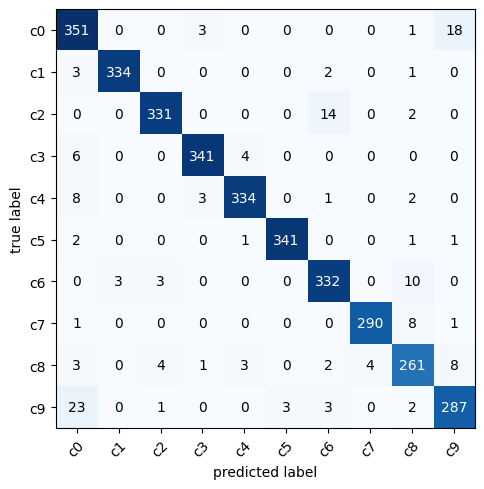

In [ ]:
predictions = model_more_filters.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes

matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(5,5), class_names = classes, show_normed=False)
plt.tight_layout()


**Evaluate the impact of data preprocessing on your model. How does it affect the accuracy and performance of the model?**

In [ ]:
train_dir = "/content/dataset/imgs/Training"
val_dir = "/content/dataset/imgs/Validation"
test_dir = "/content/dataset/imgs/Test"
target_size = (96, 96)
batch_size = 32

# Data augmentation for training data
train_datagen_unproccesed = ImageDataGenerator()
# Data generator for training data
train_generator_unproccesed = train_datagen_unproccesed.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

# Data generator for validation data
val_datagen_unproccesed = ImageDataGenerator()
validation_generator_unproccesed = val_datagen_unproccesed.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Data generator for test data
test_datagen_unproccesed = ImageDataGenerator()
test_generator_unproccesed = test_datagen_unproccesed.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 17164 images belonging to 10 classes.
Found 1902 images belonging to 10 classes.
Found 3358 images belonging to 10 classes.


In [ ]:
layers_more_filters_unproccesed = [
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(input_size, input_size, num_colors)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation= tf.nn.softmax)
]

model_more_filters_unproccesed = keras.Sequential(layers_more_filters_unproccesed, name="car_multiclass_classification_more_filters")

# Optimization algorithm and loss function configuration
model_more_filters_unproccesed.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Network structure
model_more_filters_unproccesed.summary()

Model: "car_multiclass_classification_more_filters"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 47, 47, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 22, 22, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 20, 20, 256)       295168    
                                                                 
 max_pooling2d_15 (MaxPo

In [ ]:
# Training process execution
history_filters_unproccesed = model_more_filters_unproccesed.fit(train_generator_unproccesed,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    callbacks = [tensorboard_callback])

# Evaluation of the model using the test set
predictions = model_more_filters_unproccesed.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)  # Predicted labels
y_real = test_generator_unproccesed.classes         # True labels

# Calculate precision, recall, F1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_real, y_pred, average='weighted')

# Print the classification report
print(metrics.classification_report(y_real, y_pred, digits=4))

Epoch 1/150
30/30 [==============================] - 3s 56ms/step - loss: 30.7773 - accuracy: 0.1667
Epoch 2/150
30/30 [==============================] - 2s 62ms/step - loss: 1.5410 - accuracy: 0.4771
Epoch 3/150
30/30 [==============================] - 2s 64ms/step - loss: 1.1728 - accuracy: 0.6271
Epoch 4/150
30/30 [==============================] - 2s 59ms/step - loss: 0.6869 - accuracy: 0.7760
Epoch 5/150
30/30 [==============================] - 2s 61ms/step - loss: 0.6105 - accuracy: 0.8115
Epoch 6/150
30/30 [==============================] - 2s 60ms/step - loss: 0.5341 - accuracy: 0.8469
Epoch 7/150
30/30 [==============================] - 2s 60ms/step - loss: 0.3828 - accuracy: 0.8802
Epoch 8/150
30/30 [==============================] - 2s 62ms/step - loss: 0.3321 - accuracy: 0.8969
Epoch 9/150
30/30 [==============================] - 2s 60ms/step - loss: 0.3342 - accuracy: 0.8958
Epoch 10/150
30/30 [==============================] - 2s 60ms/step - loss: 0.3288 - accuracy: 0.896

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Evaluation of the model using the test set
evaluation(model_more_filters)

105/105 [==============================] - 7s 62ms/step
              precision    recall  f1-score   support

           0     0.8841    0.9410    0.9117       373
           1     0.9911    0.9824    0.9867       340
           2     0.9764    0.9539    0.9650       347
           3     0.9799    0.9715    0.9757       351
           4     0.9766    0.9598    0.9681       348
           5     0.9913    0.9855    0.9884       346
           6     0.9379    0.9540    0.9459       348
           7     0.9864    0.9667    0.9764       300
           8     0.9062    0.9126    0.9094       286
           9     0.9111    0.8997    0.9054       319

    accuracy                         0.9535      3358
   macro avg     0.9541    0.9527    0.9533      3358
weighted avg     0.9543    0.9535    0.9538      3358

